# Connecting mocks to spectra.

This notebook presents QA checks of the code which assigns spectra to the mock catalogs.

### Initialize

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import numpy as np
import warnings
import yaml
from glob import glob

## Visualize the surface density of the input mocks.

In [3]:
# Note that you need the standard desi/conda dependencies + matplotlib, 
# basemap, and healpy to run this notebook.
import mpl_toolkits
import matplotlib.pyplot as plt

In [4]:
from desiutil.plots import init_sky, plot_sky_binned

In [5]:
def _GRFpath():
    return os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'GaussianRandomField', 'v0.0.5')

In [6]:
def read_GRF(fitsfile):
    """Read the Gaussian Random Field mocks."""
    import fitsio
    from astropy.table import Table, Column
    print('Reading {}'.format(fitsfile))
    dat = Table(fitsio.read(fitsfile, ext=1, upper=True))
    if 'random' not in fitsfile:
        dat.add_column(Column(name='Z', data=(dat['Z_COSMO'] + dat['DZ_RSD']).astype('f4')))
    return dat

In [7]:
def read_MXXL(hdf5file):
    """Read the MXXL/BGS mock."""
    import h5py
    print('Reading {}'.format(hdf5file))
    f = h5py.File(hdf5file)
    ra  = f['Data/ra'][...].astype('f8') % 360.0
    dec = f['Data/dec'][...].astype('f8')
    zobs = f['Data/z_obs'][...].astype('f4')
    rmag = f['Data/app_mag'][...].astype('f8')
    these = rmag < 20
    dat = {'RA': ra[these], 'DEC': dec[these], 'Z': zobs[these]}
    return dat

In [8]:
def qamock_sky(cat, objtype, ax=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        basemap = init_sky(galactic_plane_color='k', ax=ax[0]);
        plot_sky_binned(cat['RA'], cat['DEC'], verbose=False, 
                        clip_lo='!1', plot_type='healpix', cmap='jet', 
                        label=r'{} (targets/deg$^2$)'.format(objtype), 
                        basemap=basemap)
    if 'Z' in cat.keys():
        ax[1].hist(cat['Z'])

In [9]:
data = list()
print(r'Note: the BGS mock is selected to have $r_{SDSS}<20$, which is not quite right.')
mockfile = os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'bgs', 'MXXL', 'desi_footprint', 'v0.0.3', 'BGS.hdf5')
data.append(read_MXXL(mockfile))

for mock in ('ELG', 'LRG', 'QSO'):
    mockfile = os.path.join(_GRFpath(), '{}.fits'.format(mock))
    data.append(read_GRF(mockfile))

mockfile = os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'GaussianRandomField', 'v0.0.1', '2048', 'random.fits')
data.append(read_GRF(mockfile))

Note: the BGS mock is selected to have $r_{SDSS}<20$, which is not quite right.
Reading /Users/ioannis/research/projects/desi/mocks/bgs/MXXL/desi_footprint/v0.0.3/BGS.hdf5
Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5/ELG.fits
Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5/LRG.fits
Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5/QSO.fits
Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.1/2048/random.fits


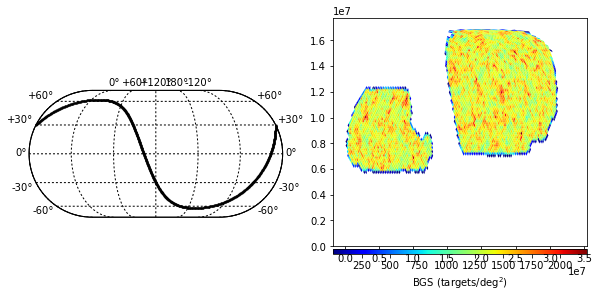

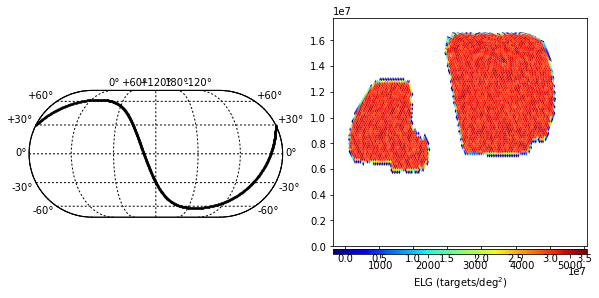

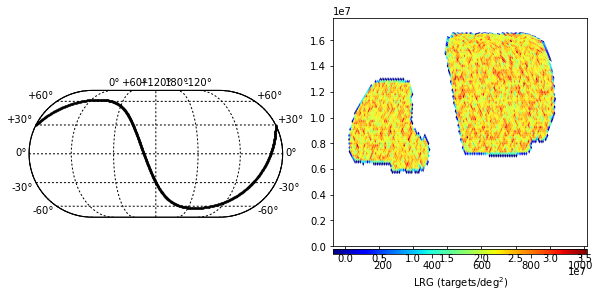

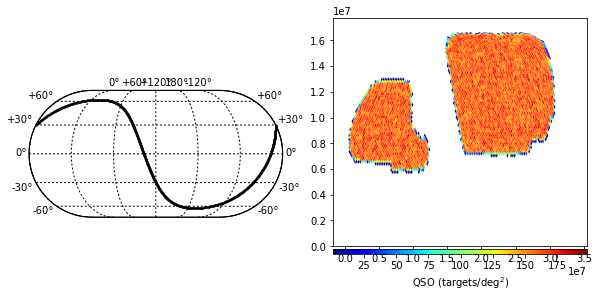

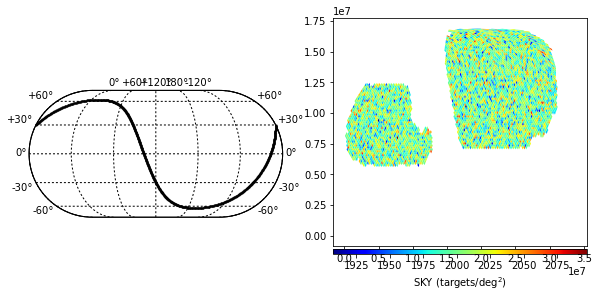

In [10]:
# Why doesn't this work?!?
for cat, objtype in zip(data, ('BGS', 'ELG', 'LRG', 'QSO', 'SKY')):
#for cat, objtype in zip(data, np.atleast_1d('BGS')):
    qamock_sky(cat, objtype)

## Assess the QSO mock targets, spectra, and contaminants.

In [11]:
from desitarget.mock.build import targets_truth

In [12]:
two_percent_path = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'two_percent')

### Generate a QSO target catalog.

In [13]:
def target_yaml(target='QSO', bounds=(203, 204, 0, 1), outfile='mock_input.yaml', verbose=False):
    """Write a target yaml file on-the-fly for various combinations of input parameters."""
    print('Writing {}'.format(outfile))
    yf = open(outfile, 'w')
    yf.write('dust_dir: {}\n'.format(os.path.join(os.getenv('DUST_DIR'), 'maps')))
    yf.write('decals_brick_info: {}\n'.format(os.path.join(os.getenv('DESI_ROOT'), 'target', 
                                                           'catalogs', 'brick-info-dr3.v0.0.1.fits')))
    yf.write('subset:\n')
    yf.write('    ra_dec_cut: True\n')
    for blabel, bbound in zip(('min_ra', 'max_ra', 'min_dec', 'max_dec'), bounds):
        yf.write('    {}: {:g}\n'.format(blabel, bbound))
    yf.write('sources:\n')
    for targ in np.atleast_1d(target):
        yf.write('    {}: {{\n'.format(targ.upper()))
        yf.write('        target_name: {},\n'.format(targ.upper()))
        if targ == 'QSO':
            yf.write('        mock_dir_name: {},\n'.format(_GRFpath()))
            yf.write('        format: gaussianfield,\n')
            yf.write('        density: 170\n')
        yf.write('    }\n')
    yf.close()    
    if verbose:
        print()
        with(open(outfile, 'r')) as yf:
            print(yf.read())

In [14]:
config_file = os.path.join(two_percent_path, 'qso_input.yaml')
target_yaml(target='QSO', outfile=config_file, verbose=True)

Writing /Users/ioannis/research/projects/desi/datachallenge/two_percent/qso_input.yaml

dust_dir: /Users/ioannis/research/data/sfd_dustmaps/maps
decals_brick_info: /Users/ioannis/research/projects/desi/target/catalogs/brick-info-dr3.v0.0.1.fits
subset:
    ra_dec_cut: True
    min_ra: 203
    max_ra: 204
    min_dec: 0
    max_dec: 1
sources:
    QSO: {
        target_name: QSO,
        mock_dir_name: /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5,
        format: gaussianfield,
        density: 170
    }



In [15]:
output_dir = os.path.join(two_percent_path, 'qso_targets')
bricksize = 0.25
seed = 555
nproc = 4
with open(config_file, 'r') as pfile:
    params = yaml.load(pfile)
targets_truth(params, output_dir, realtargets=None, seed=seed, verbose=True, 
              nproc=nproc, bricksize=bricksize, outbricksize=bricksize)

INFO:build.py:132:generate_brick_info: Generating brick information for 30 brick(s) with boundaries RA=203, 204, Dec=0, 1 and bricksize 0.25 deg.
INFO:build.py:497:targets_truth: Initializing the MockSpectra and SelectTargets classes.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/elg_templates_v2.0.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/lrg_templates_v1.3.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/qso_templates_v2.0

INFO:build.py:436:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/two_percent/qso_targets/203/truth-2033p010.fits.
INFO:build.py:436:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/two_percent/qso_targets/203/truth-2033p002.fits.
INFO:build.py:436:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/two_percent/qso_targets/203/truth-2036p000.fits.
INFO:build.py:436:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/two_percent/qso_targets/203/truth-2036p002.fits.
INFO:build.py:436:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/two_percent/qso_targets/203/truth-2038p010.fits.
INFO:build.py:436:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/two_percent/qso_targets/203/truth-2031p007.fits.
INFO:build.py:436:write_onebrick: Writing /Users/ioannis/research/projects/desi/datachallenge/two_percent/qso_targets/203/truth-2031p002.fits.

### Read the catalog back in and make some plots.